## install package

In [1]:
!pip install -U datasets

  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 3.2.0
    Uninstalling datasets-3.2.0:
      Successfully uninstalled datasets-3.2.0


In [2]:
!pip install fsspec==2023.9.2

  Using cached fsspec-2023.9.2-py3-none-any.whl.metadata (6.7 kB)
Using cached fsspec-2023.9.2-py3-none-any.whl (173 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0


In [3]:
!pip install -U transformers

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.31.4-py3-none-any.whl.metadata (13 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
Using cached huggingface_hub-0.31.4-py3-none-any.whl (489 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 0.27.1
    Uninstalling huggingface_hub-0.27.1:
      Successfully uninstalled huggingface_hub-0.27.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.0
    Uninstalling transformers-4.48.0:
      Successfully uninstalled transformers-4.48.0


In [4]:
!pip install opencc

  Using cached OpenCC-1.1.9-cp311-cp311-win_amd64.whl.metadata (14 kB)
Using cached OpenCC-1.1.9-cp311-cp311-win_amd64.whl (1.8 MB)


In [12]:
!pip install -U scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.1 MB 6.1 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.1 MB 5.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.1 MB 5.0 MB/s eta 0:00:02
   -------------- ------------------------- 3.9/11.1 MB 4.7 MB/s eta 0:00:02
   ------------------- -------------------- 5.5/11.1 MB 5.4 MB/s eta 0:00:02
   -------------------------- ------------- 7.3/11.1 MB 6.0 MB/s eta 0:00:01
   --------------------------------- ------ 9.4/11.1 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 6.6 MB/s eta 0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.6.3 requires patsy>=0.5.1, which is not installed.
category-encoders 2.6.3 requires statsmodels>=0.9.0, which is not installed.
pyod 1.1.3 requires numba>=0.51, which is not installed.
sktime 0.28.0 requires scikit-base<0.8.0, which is not installed.
tbats 1.1.3 requires pmdarima, which is not installed.
sktime 0.28.0 requires numpy<1.27,>=1.21, but you have numpy 2.2.2 which is incompatible.
sktime 0.28.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.6.1 which is incompatible.


In [1]:
from huggingface_hub import login
login()  # 跳出提示，貼上你的 Token

## dataset prepare

In [39]:
from datasets import load_dataset, Dataset
import pandas as pd
import itertools
import opencc
import random

MAX_LENGTH = 512

# 1. streaming 抽樣 function
def sample_streaming(dataset_name, split, num_samples):
    stream = load_dataset(dataset_name, split=split, streaming=True)
    sampled = list(itertools.islice(stream, num_samples))
    df = pd.DataFrame(sampled)
    col = "text" if "text" in df.columns else df.columns[0]
    df = df[[col]].rename(columns={col: "text"})
    return df

# 2. 分別抽樣
df_trad = sample_streaming("voidful/fineweb-zhtw", "train", 55000)
df_trad["label"] = 1

df_simp = sample_streaming("opencsg/chinese-fineweb-edu", "train", 85000)
df_simp["label"] = 0

# 3. 標記已有 text，建立集合
used_texts = set(df_trad["text"]).union(set(df_simp["text"]))

# 4. 批次 streaming，過濾全新文本，直到收集夠多新資料
def sample_unique_streaming(dataset_name, split, num_samples, exclude_texts):
    stream = load_dataset(dataset_name, split=split, streaming=True)
    result = []
    for sample in stream:
        t = sample["text"] if "text" in sample else list(sample.values())[0]
        if t not in exclude_texts:
            result.append(t)
            if len(result) >= num_samples:
                break
    return pd.DataFrame({"text": result})

# 5. 重新 streaming 不重複的混合資料
df_mixed_raw = sample_unique_streaming(
    "voidful/fineweb-zhtw", "train", 40000, used_texts
)
converter = opencc.OpenCC('t2s.json')

# 改良：讓簡體分布於不同區段
def random_hybrid_segments_distributed(trad_text, segment_num=3):
    trad_chars = list(trad_text)
    simp_chars = list(converter.convert(trad_text))
    N = len(trad_chars)
    hybrid = trad_chars.copy()
    if N < 2 or segment_num < 1:
        return trad_text
    # 平均分佈每個簡體片段
    span = N // segment_num
    for seg in range(segment_num):
        start = seg * span
        end = min(start + max(1, span // 2), N)
        for i in range(start, end):
            hybrid[i] = simp_chars[i]
    return "".join(hybrid)

df_mixed_raw["text"] = df_mixed_raw["text"].apply(lambda x: random_hybrid_segments_distributed(x, segment_num=3))
df_mixed_raw["label"] = 2

# 6. 合併
df_total = pd.concat([df_trad, df_simp, df_mixed_raw], ignore_index=True)

# 7. 長文本切片為多個樣本
def split_long_text(text, label, max_length=MAX_LENGTH):
    if len(text) <= max_length:
        return [{"text": text, "label": label}]
    return [{"text": text[i:i+max_length], "label": label}
            for i in range(0, len(text), max_length)]

records = []
for _, row in df_total.iterrows():
    records.extend(split_long_text(row["text"], row["label"], MAX_LENGTH))
df_total = pd.DataFrame(records)

# 刪除所有長度 < 10 的樣本
df_total = df_total[df_total["text"].str.len() >= 10].reset_index(drop=True)


# 8. 亂數排序
df_total = df_total.sample(frac=1.0, random_state=42).reset_index(drop=True)

# 9. 轉 Hugging Face Dataset
dataset = Dataset.from_pandas(df_total[["text", "label"]])

# 10. 長度分布監控（可選）
lengths = df_total["text"].str.len()
print(f"文本長度統計: \n{lengths.describe()}")
overlong_ratio = (lengths >= MAX_LENGTH).mean()
print(f">={MAX_LENGTH}字的樣本比例: {overlong_ratio:.2%}")
if overlong_ratio > 0.3:
    print("警告：超長文本比例仍然過高，建議再檢查資料清理！")


Resolving data files:   0%|          | 0/322 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/322 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/308 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/322 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/322 [00:00<?, ?it/s]

文本長度統計: 
count    572485.000000
mean        435.964165
std         138.648757
min          10.000000
25%         415.000000
50%         512.000000
75%         512.000000
max         512.000000
Name: text, dtype: float64
>=512字的樣本比例: 69.14%
警告：超長文本比例仍然過高，建議再檢查資料清理！


## tokenizer

In [ ]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ckiplab/bert-base-chinese")

# 1. 讀入資料
df = dataset.to_pandas()   # 注意這裡要和 stratify 來源一致
df_train, df_val = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'],   # 修正，df_total 應改為 df，來源一致
    random_state=42
)

# 2. 轉換為 Hugging Face DatasetDict
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "validation": Dataset.from_pandas(df_val.reset_index(drop=True))
})

# 3. Tokenize（保留欄位）
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

# encoded_dataset 會自動多欄位（input_ids, attention_mask, ...）
encoded_dataset = raw_datasets.map(tokenize, batched=True)

# 可選：檢查一下分布
print("train label 分布：\n", df_train["label"].value_counts(normalize=True))
print("val label 分布：\n", df_val["label"].value_counts(normalize=True))


Map:   0%|          | 0/457988 [00:00<?, ? examples/s]

Map:   0%|          | 0/114497 [00:00<?, ? examples/s]

## Finetune

In [ ]:
labels = set(dataset["label"])
print("所有 label:", labels)
print("最大:", max(labels), "最小:", min(labels))

所有 label: {0, 1, 2}
最大: 2 最小: 0


In [ ]:
# 若使用 pandas DataFrame
labels_set = set(encoded_dataset["train"]["label"])
print("所有 label:", labels_set)
assert labels_set.issubset({0, 1, 2}), "labels 有超出 0/1/2 的數值"

import numpy as np
print("有無 NaN:", np.isnan(encoded_dataset["train"]["label"]).any())
print("dtype:", type(encoded_dataset["train"]["label"][0]))
encoded_dataset = encoded_dataset.map(lambda x: {"label": int(x["label"])})

所有 label: {0, 1, 2}
有無 NaN: False
dtype: <class 'int'>


Map:   0%|          | 0/457988 [00:00<?, ? examples/s]

Map:   0%|          | 0/114497 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "ckiplab/bert-base-chinese",
    num_labels=3,
    hidden_dropout_prob=0.3,  # 適度防過擬合
)

training_args = TrainingArguments(
    output_dir="./model_ckpt",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    weight_decay=0.1,
    warmup_ratio=0.06,
    save_strategy="steps",         # 改為 "steps"
    save_steps=1000,               # 每1000步存一次
    logging_strategy="steps",
    logging_steps=200,
    eval_strategy="steps",         # 和 save 保持一致
    eval_steps=1000,               # 每1000步驗證一次（和 save_steps 一樣）
    save_total_limit=2,
    fp16=True,
    seed=42,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_num_workers=2,
    disable_tqdm=False,
    max_grad_norm=1.0,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17296\2449847304.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
1000,0.171600,0.159915
2000,0.155300,0.141052
3000,0.148800,0.142465
4000,0.143300,0.141661
5000,0.143500,0.136497
6000,0.137400,0.134131
7000,0.140900,0.133454
8000,0.139100,0.137947
9000,0.140100,0.139742
10000,0.135000,0.133670


TrainOutput(global_step=21468, training_loss=0.14531176330569248, metrics={'train_runtime': 18994.5701, 'train_samples_per_second': 72.335, 'train_steps_per_second': 1.13, 'total_flos': 9.036840822602342e+16, 'train_loss': 0.14531176330569248, 'epoch': 2.999650667225599})

In [26]:
model.save_pretrained("./bert-zh-tw-classifier")
tokenizer.save_pretrained("./bert-zh-tw-classifier")

('./bert-zh-tw-classifier\\tokenizer_config.json',
 './bert-zh-tw-classifier\\special_tokens_map.json',
 './bert-zh-tw-classifier\\vocab.txt',
 './bert-zh-tw-classifier\\added_tokens.json',
 './bert-zh-tw-classifier\\tokenizer.json')

In [27]:
trainer.save_model("./model_ckpt")  # 這會同時儲存 model 和 config.json
tokenizer.save_pretrained("./model_ckpt")


('./model_ckpt\\tokenizer_config.json',
 './model_ckpt\\special_tokens_map.json',
 './model_ckpt\\vocab.txt',
 './model_ckpt\\added_tokens.json',
 './model_ckpt\\tokenizer.json')

In [28]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

classifier = pipeline("text-classification", model="./model_ckpt", tokenizer="./model_ckpt")
classifier("欢迎来到台灣")


Device set to use cuda:0


[{'label': 'LABEL_2', 'score': 0.9333289265632629}]

In [29]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.13141664862632751, 'eval_runtime': 243.8417, 'eval_samples_per_second': 469.555, 'eval_steps_per_second': 7.341, 'epoch': 2.999650667225599}


In [30]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer, TrainingArguments

# 1. 準備 test dataset（假設叫 encoded_dataset["validation"]，你也可替換為 test set）
eval_dataset = encoded_dataset["validation"]

# 2. 用 Trainer 進行預測
preds_output = trainer.predict(eval_dataset)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# 3. 計算 classification report
target_names = ["簡體", "繁體", "混合"]
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("=== Classification Report ===")
print(report)


=== Classification Report ===
              precision    recall  f1-score   support

          簡體     0.9991    0.9998    0.9994     59781
          繁體     0.8420    0.9916    0.9107     31729
          混合     0.9848    0.7415    0.8460     22987

    accuracy                         0.9456    114497
   macro avg     0.9420    0.9109    0.9187    114497
weighted avg     0.9527    0.9456    0.9440    114497



=== Confusion Matrix ===
[[59767     5     9]
 [   12 31463   254]
 [   42  5901 17044]]


c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 31777 (\N{CJK UNIFIED IDEOGRAPH-7C21}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 39636 (\N{CJK UNIFIED IDEOGRAPH-9AD4}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 32321 (\N{CJK UNIFIED IDEOGRAPH-7E41}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ASUS\miniconda3\envs\VPPM\Lib\site-packages\IPython\core\pyla

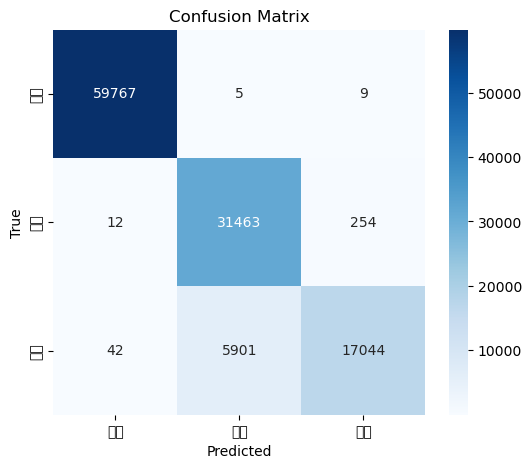

In [31]:
# 混淆矩陣
cm = confusion_matrix(y_true, y_pred)
print("=== Confusion Matrix ===")
print(cm)

# 若需視覺化（需要 matplotlib）
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


⚠️ 未找到合適中文字型，請手動下載並設置 font_path。


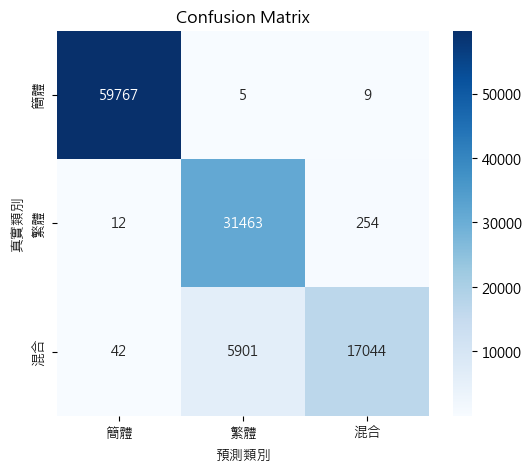

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 1. 設定中文字型（自動尋找系統字型，常見有「SimHei」「Noto Sans CJK」「Microsoft JhengHei」）
font_path = ""
for candidate in ['NotoSansCJK-TC-Regular.otf', 'SimHei.ttf', 'Microsoft JhengHei.ttf']:
    fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
    for f in fonts:
        if candidate in f:
            font_path = f
            break
    if font_path:
        break

if not font_path:
    print("⚠️ 未找到合適中文字型，請手動下載並設置 font_path。")

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Noto Sans CJK TC', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 2. 繪製 confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['簡體', '繁體', '混合'], 
            yticklabels=['簡體', '繁體', '混合'])
plt.xlabel('預測類別')
plt.ylabel('真實類別')
plt.title('Confusion Matrix')
plt.show()


In [32]:
import pandas as pd

df_check = pd.DataFrame({
    'true': y_true,
    'pred': y_pred
})

# 各類預測與真實分布
print("=== 預測類別分布 ===")
print(df_check['pred'].value_counts().sort_index())

print("=== 真實類別分布 ===")
print(df_check['true'].value_counts().sort_index())

# 檢查系統性誤判：真實為某一類但常被預測為另一類
for true_label in range(3):
    misclassified = df_check[(df_check['true'] == true_label) & (df_check['pred'] != true_label)]
    print(f"--- 真實類別 {target_names[true_label]} 被誤判分布 ---")
    print(misclassified['pred'].value_counts())


=== 預測類別分布 ===
pred
0    59821
1    37369
2    17307
Name: count, dtype: int64
=== 真實類別分布 ===
true
0    59781
1    31729
2    22987
Name: count, dtype: int64
--- 真實類別 簡體 被誤判分布 ---
pred
2    9
1    5
Name: count, dtype: int64
--- 真實類別 繁體 被誤判分布 ---
pred
2    254
0     12
Name: count, dtype: int64
--- 真實類別 混合 被誤判分布 ---
pred
1    5901
0      42
Name: count, dtype: int64


## PUSH

In [33]:
from huggingface_hub import notebook_login

notebook_login()


In [34]:
from transformers import AutoTokenizer

# 儲存模型與 tokenizer
model.save_pretrained("./model_ckpt")
tokenizer.save_pretrained("./model_ckpt")

# 推送到 Hugging Face
from huggingface_hub import HfApi, create_repo, upload_folder

# repo_id 建議格式："username/model-name"
repo_id = "renhehuang/bert-base-chinese-traditional-classifier-v3"
create_repo(repo_id, private=False)  # 若要私有改成 private=True

# 將整個資料夾上傳
upload_folder(
    folder_path="./model_ckpt",
    repo_id=repo_id,
    commit_message="Initial commit"
)


model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/818M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Upload 14 LFS files:   0%|          | 0/14 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/818M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/renhehuang/bert-base-chinese-traditional-classifier-v3/commit/24e0df7fc153c72e21922bdb8c0052cba9efd13b', commit_message='Initial commit', commit_description='', oid='24e0df7fc153c72e21922bdb8c0052cba9efd13b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/renhehuang/bert-base-chinese-traditional-classifier-v3', endpoint='https://huggingface.co', repo_type='model', repo_id='renhehuang/bert-base-chinese-traditional-classifier-v3'), pr_revision=None, pr_num=None)

## test

In [36]:
import random
import pandas as pd

trad_samples = [
    "這是一個繁體中文的測試句子。", "歡迎來到台灣！", "請問您需要什麼協助？",
    "我們今天學習了很多知識。", "天氣很好，適合出門散步。", "你喜歡吃什麼台灣小吃？",
    "這本書很有趣，推薦你看看。", "捷運系統非常方便。", "週末一起去看電影好嗎？", "我在圖書館讀書。"
]
simp_samples = [
    "这是一个简体中文的测试句子。", "欢迎来到中国！", "请问您需要什么帮助？",
    "我们今天学到了很多知识。", "天气很好，适合出去散步。", "你喜欢吃什么中国小吃？",
    "这本书很有趣，推荐你看看。", "地铁系统非常方便。", "周末一起去看电影好吗？", "我在图书馆学习。"
]

def random_samples(source, n):
    return [random.choice(source) for _ in range(n)]

def mixed_samples(trad_source, simp_source, n, trad_ratio):
    n_trad = int(n * trad_ratio)
    n_simp = n - n_trad
    return random_samples(trad_source, n_trad) + random_samples(simp_source, n_simp)

trad_data = random_samples(trad_samples, 50)
simp_data = random_samples(simp_samples, 50)
mix1_data = mixed_samples(trad_samples, simp_samples, 50, trad_ratio=0.7)
random.shuffle(mix1_data)
mix2_data = mixed_samples(trad_samples, simp_samples, 50, trad_ratio=0.3)
random.shuffle(mix2_data)

test_df = pd.DataFrame({
    "group": ["trad"]*50 + ["simp"]*50 + ["mix1"]*50 + ["mix2"]*50,
    "text": trad_data + simp_data + mix1_data + mix2_data
})


In [37]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./model_ckpt", tokenizer="./model_ckpt", device=0)  # CUDA
results = [classifier(t)[0] for t in test_df["text"]]
test_df["pred_label"] = [r["label"] for r in results]
test_df["score"] = [r["score"] for r in results]


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [38]:
summary = test_df.groupby("group")["pred_label"].value_counts().unstack(fill_value=0)
print("分類結果分布：")
print(summary)


分類結果分布：
pred_label  LABEL_0  LABEL_1  LABEL_2
group                                
mix1              5       35       10
mix2             10       15       25
simp             17        0       33
trad              0       50        0


In [ ]:
score_stats = test_df.groupby("group")["score"].agg(["mean", "std", "min", "max"])
print("\n信心分數統計：")
print(score_stats)
